In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score

- Women with ADHD penalized twice as much 
- Try graph neural net and convolutional neural net

### Load in the training data

In [2]:
# Use read_excel and use participant_id as the index
train_cat = pd.read_excel("../data/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
train_func = pd.read_csv("../data/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
train_quant = pd.read_excel("../data/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
train_soln = pd.read_excel("../data/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")

In [3]:
display(train_cat.head(), train_func.head(), train_quant.head(), train_soln.head())

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN
1,00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0
2,04X1eiS79T4B,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN
3,05ocQutkURd6,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0
4,06YUNBA9ZRLq,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN


,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,70z8Q2xdTXM3,0.222930,0.527903,0.429966,0.060457,0.566489,0.315342,0.508408,-0.078290,0.525692,...,0.224985,0.397448,0.422966,0.184642,0.305549,0.420349,0.016328,0.561864,0.471170,0.365221
1,WHWymJu6zNZi,0.614765,0.577255,0.496127,0.496606,0.404686,0.439724,0.122590,-0.085452,0.120673,...,0.217546,-0.014549,0.000440,-0.096451,0.454501,0.343916,0.167313,0.607656,0.550623,0.503176
2,4PAQp1M6EyAo,-0.116833,0.458408,0.260703,0.639031,0.769337,0.442528,0.637110,0.192010,0.520379,...,0.342487,-0.021141,-0.037836,0.075069,0.412712,0.292708,0.391005,0.461544,0.508912,0.624232
3,obEacy4Of68I,0.199688,0.752714,0.658283,0.575096,0.692867,0.645789,0.522750,0.412188,0.530843,...,0.103562,-0.178313,0.210983,-0.018666,0.436313,0.592982,0.216205,0.341272,0.440313,0.558193
4,s7WzzDcmDOhF,0.227321,0.613268,0.621447,0.562673,0.736709,0.589813,0.266676,0.359668,0.300771,...,-0.164956,0.007064,-0.120904,-0.488095,0.493575,-0.215361,0.210685,0.055850,0.119065,0.108273


,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN
2,04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1


In [4]:
data_dict = pd.read_excel("../data/Data Dictionary.xlsx")
data_dict

,DataType,Instrument,Field,Description,Type,Labels
0,QUANTITATIVE METADATA,NaN,NaN,NaN,NaN,NaN
1,NaN,Identifier,participant_id,Participant ID,str,NaN
2,Quantitative,Edinburgh Handedness Questionnaire,EHQ_EHQ_Total,Laterality Index (Score),float,-100 = 10th left\n−28 ≤ LI < 48 = middle\n100 ...
3,Quantitative,Ishihara Color Vision Test,ColorVision_CV_Score,Color vision test score,int,NaN
4,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_CP,Corporal Punishment Score,int,NaN
5,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_ID,Inconsistent Discipline Score,int,NaN
6,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_INV,Involvement Score,int,NaN
7,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_OPD,Other Discipline Practices Score (Not factored...,int,NaN
8,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_PM,Poor Monitoring/Supervision Score,int,NaN
9,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_PP,Positive Parenting Score,int,NaN


## train_cat: One-hot encoding on the categorical values
1. Turn the numbers into their labels using the values provided in the data dictionary.
2. Use pandas to perform one-hot encoding so that the models can interpret the binary values instead of arbitrary numbers.

In [5]:
Basic_Demos_Study_Site = {
    1: "Staten Island",
    2: "MRV",
    3: "Midtown",
    4: "Harlem",
    5: "SI RUMC",
}

PreInt_Demos_Fam_Child_Ethnicity = {
    0: "Not Hispanic or Latino",
    1: "Hispanic or Latino",
    2: "Decline to specify",
    3: "Unknown"
}

PreInt_Demos_Fam_Child_Race = {
  0: "White/Caucasian",
  1: "Black/African American",
  2: "Hispanic",
  3: "Asian",
  4: "Indian",
  5: "Native American Indian",
  6: "American Indian/Alaskan Native",
  7: "Native Hawaiian/Other Pacific Islander",
  8: "Two or more races",
  9: "Other race",
  10: "Unknown",
  11: "Chose not to specify"}

MRI_Track_Scan_Location = {
    1: "Staten Island",
    2: "RUBIC", 
    3: "CBIC",
    4: "CUNY"
}

Barratt_Barratt_P1_Edu = {
    3: "Less than 7th grade",
    6: "Junior high/Middle school (9th grade)",
    9: "Partial high school (10th or 11th grade)",
    12: "High school graduate",
    15: "Partial college (at least one year)",
    18: "College education",
    21: "Graduate degree"
}

Barratt_Barratt_P1_Occ = {
    0: "Homemaker, stay at home parent.",
    5: "Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy.",
    10: "Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter.",
    15: "Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk.",
    20: "Automobile mechanic, typist, locksmith, farmer, carpenter, receptionist, construction laborer, hairdresser.",
    25: "Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder.",
    30: "Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer.",
    35: "Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist.",
    40: "Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementary, high school and special education teacher.",
    45: "Physician, attorney, professor, chemical and aerospace engineer, judge, CEO, senior manager, public official, psychologist, pharmacist, accountant."
}

Barratt_Barratt_P2_Edu = {
    3: "Less than 7th grade",
    6: "Junior high/Middle school (9th grade)",
    9: "Partial high school (10th or 11th grade)",
    12: "High school graduate",
    15: "Partial college (at least one year)",
    18: "College education",
    21: "Graduate degree"
}

Barratt_Barratt_P2_Occ = {
    0: "Homemaker, stay at home parent.",
    5: "Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy.",
    10: "Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter.",
    15: "Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk.",
    20: "Automobile mechanic, typist, locksmith, farmer, carpenter, receptionist, construction laborer, hairdresser.",
    25: "Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder.",
    30: "Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer.",
    35: "Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist.",
    40: "Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementary, high school and special education teacher.",
    45: "Physician, attorney, professor, chemical and aerospace engineer, judge, CEO, senior manager, public official, psychologist, pharmacist, accountant.",
}



In [6]:
# Apply label replacements using the dictionaries
train_cat["Basic_Demos_Study_Site"] = train_cat["Basic_Demos_Study_Site"].replace(
    Basic_Demos_Study_Site
)
train_cat["PreInt_Demos_Fam_Child_Ethnicity"] = train_cat[
    "PreInt_Demos_Fam_Child_Ethnicity"
].replace(PreInt_Demos_Fam_Child_Ethnicity)
train_cat["PreInt_Demos_Fam_Child_Race"] = train_cat[
    "PreInt_Demos_Fam_Child_Race"
].replace(PreInt_Demos_Fam_Child_Race)
train_cat["MRI_Track_Scan_Location"] = train_cat["MRI_Track_Scan_Location"].replace(
    MRI_Track_Scan_Location
)
train_cat["Barratt_Barratt_P1_Edu"] = train_cat["Barratt_Barratt_P1_Edu"].replace(
    Barratt_Barratt_P1_Edu
)
train_cat["Barratt_Barratt_P1_Occ"] = train_cat["Barratt_Barratt_P1_Occ"].replace(
    Barratt_Barratt_P1_Occ
)
train_cat["Barratt_Barratt_P2_Edu"] = train_cat["Barratt_Barratt_P2_Edu"].replace(
    Barratt_Barratt_P2_Edu
)
train_cat["Barratt_Barratt_P2_Occ"] = train_cat["Barratt_Barratt_P2_Occ"].replace(
    Barratt_Barratt_P2_Occ
)

In [7]:
# One-hot encode all columns except 'participant_id' and 'Basic_Demos_Enroll_Year'
train_cat_encoded = pd.get_dummies(
    train_cat,
    columns=[
        "Basic_Demos_Study_Site",
        "PreInt_Demos_Fam_Child_Ethnicity",
        "PreInt_Demos_Fam_Child_Race",
        "MRI_Track_Scan_Location",
        "Barratt_Barratt_P1_Edu",
        "Barratt_Barratt_P1_Occ",
        "Barratt_Barratt_P2_Edu",
        "Barratt_Barratt_P2_Occ",
    ],
    dummy_na=True,  # Optional: adds a column for NaNs if present
    drop_first=False,  # Set to True if you want to drop the first category to avoid multicollinearity
)

# Check the result
train_cat_encoded.head()

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site_Harlem,Basic_Demos_Study_Site_MRV,Basic_Demos_Study_Site_Midtown,Basic_Demos_Study_Site_Staten Island,Basic_Demos_Study_Site_nan,PreInt_Demos_Fam_Child_Ethnicity_Decline to specify,PreInt_Demos_Fam_Child_Ethnicity_Hispanic or Latino,PreInt_Demos_Fam_Child_Ethnicity_Not Hispanic or Latino,...,"Barratt_Barratt_P2_Occ_Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy.","Barratt_Barratt_P2_Occ_Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter.","Barratt_Barratt_P2_Occ_Homemaker, stay at home parent.","Barratt_Barratt_P2_Occ_Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder.","Barratt_Barratt_P2_Occ_Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementary, high school and special education teacher.","Barratt_Barratt_P2_Occ_Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist.","Barratt_Barratt_P2_Occ_Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk.","Barratt_Barratt_P2_Occ_Physician, attorney, professor, chemical and aerospace engineer, judge, CEO, senior manager, public official, psychologist, pharmacist, accountant.","Barratt_Barratt_P2_Occ_Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer.",Barratt_Barratt_P2_Occ_nan
0,00aIpNTbG5uh,2019,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
1,00fV0OyyoLfw,2017,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,04X1eiS79T4B,2017,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
3,05ocQutkURd6,2018,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,06YUNBA9ZRLq,2018,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True


## train_func: reduce the dimensionality of the functional MRI connectome matrix

Original shape: (1213, 19900)
Transformed shape: (1213, 464)


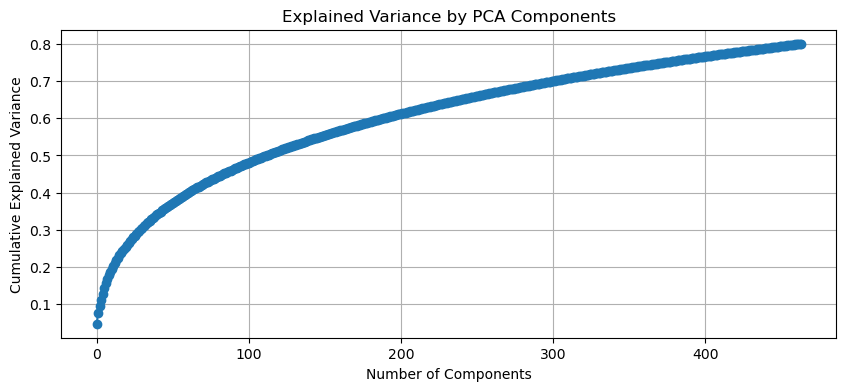

In [65]:
# Separate the features (connectome matrix) from the participant IDs
X = train_func.drop(columns=["participant_id"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Want to capture 75% of the variance
pca = PCA(n_components=0.80)
X_pca = pca.fit_transform(X_scaled)

# Shape of the transformed data
print("Original shape:", X_scaled.shape)
print("Transformed shape:", X_pca.shape)

# Explained variance
plt.figure(figsize=(10, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

In [66]:
train_func_pca = pd.DataFrame(
    X_pca,
    index=train_func["participant_id"],
    columns=[f"fmri_pca_{i+1}" for i in range(X_pca.shape[1])],
)
train_func_pca.head()

,fmri_pca_1,fmri_pca_2,fmri_pca_3,fmri_pca_4,fmri_pca_5,fmri_pca_6,fmri_pca_7,fmri_pca_8,fmri_pca_9,fmri_pca_10,...,fmri_pca_455,fmri_pca_456,fmri_pca_457,fmri_pca_458,fmri_pca_459,fmri_pca_460,fmri_pca_461,fmri_pca_462,fmri_pca_463,fmri_pca_464
participant_id,,,,,,,,,,,,,,,,,,,,,
70z8Q2xdTXM3,35.753597,0.090543,-20.350098,-19.088315,-30.805000,2.306746,0.012355,-16.080110,-6.713655,7.132238,...,2.444320,2.246306,-0.601253,-0.318204,-2.567000,-4.188951,-0.423559,2.751428,1.282703,-4.683491
WHWymJu6zNZi,28.459455,-18.887916,10.232790,-1.115161,-7.235638,-14.893705,5.991655,-3.274425,-18.623446,-12.154646,...,0.823866,-3.250062,-5.154873,4.001859,1.863844,-1.724962,3.029928,1.894485,0.494266,-5.851479
4PAQp1M6EyAo,0.798687,4.718468,10.989505,17.687384,10.643912,31.792714,-9.804087,16.585635,-15.010728,-8.778202,...,-5.095345,-3.494166,1.078176,-0.983331,-4.876152,-3.644965,-1.572020,-0.539341,-1.401308,0.602506
obEacy4Of68I,-45.767171,-11.453186,4.095472,-12.695696,-20.976370,22.331782,4.630708,-4.709863,0.145218,10.252135,...,-8.181315,3.897831,0.253571,0.590245,-0.110259,0.937680,-0.855990,5.276611,-3.118190,2.629994
s7WzzDcmDOhF,3.746646,-8.847485,10.058838,2.305610,-3.341812,14.484016,28.106098,5.519340,-6.920033,4.655665,...,3.944539,-2.646924,1.673610,3.358918,1.923088,-0.500143,1.875633,0.253948,-0.448169,4.047551


In [67]:
# Deal with NaN values
train_quant = train_quant.fillna(
    train_quant.drop("participant_id", axis=1).mean()
)
train_quant.head()

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,11.245678
2,04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


### Make one input matrix X by merging on participant_id
Currently, the dataframes are:
- train_cat_encoded (one-hot encoded so all binary)
- train_func_pca (reduced to 374 PCs)
- train_quant (dealt with NaN values)
- they all have 1213 rows, so the merging shouldn't lose any data
- they all have the participant_id column, which will uniquely merge each row

In [68]:
cat_func_merge = pd.merge(train_cat_encoded, train_func_pca, how='outer', on="participant_id")
X = pd.merge(cat_func_merge, train_quant, how="outer", on="participant_id")
X = X.drop("participant_id", axis=1)
# Turn boolean columns into integers (0/1)
X = X.astype({col: int for col in X.select_dtypes("bool").columns})
X.head()

,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site_Harlem,Basic_Demos_Study_Site_MRV,Basic_Demos_Study_Site_Midtown,Basic_Demos_Study_Site_Staten Island,Basic_Demos_Study_Site_nan,PreInt_Demos_Fam_Child_Ethnicity_Decline to specify,PreInt_Demos_Fam_Child_Ethnicity_Hispanic or Latino,PreInt_Demos_Fam_Child_Ethnicity_Not Hispanic or Latino,PreInt_Demos_Fam_Child_Ethnicity_Unknown,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,2019,1,0,0,0,0,0,1,0,0,...,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,2017,0,0,0,1,0,0,0,1,0,...,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,11.245678
2,2017,0,0,0,1,0,0,1,0,0,...,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,2018,0,0,0,1,0,0,0,0,1,...,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,2018,0,0,0,1,0,0,0,1,0,...,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


In [69]:
train_soln.head()

,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1


In [70]:
y_sex = train_soln["Sex_F"]  
y_adhd = train_soln["ADHD_Outcome"] 

In [71]:
# Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y_sex, test_size=0.2, random_state=42
)

In [72]:
# Scale inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = X_train_scaled.astype(np.float32) # Trying to debug memory issues
X_val_scaled = scaler.transform(X_val)

In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_train_tensor = X_train_tensor.to("cpu")
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

print(X_train_tensor.size())

torch.Size([970, 547])


In [76]:
from sklearn.utils.class_weight import compute_class_weight
import torch

# Assuming y_train_tensor contains the training labels
class_weights = compute_class_weight(
    class_weight="balanced", classes=[0, 1], y=y_train_tensor.numpy().flatten()
)

# Convert to tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [77]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()  # for binary classification

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

Epoch [0/50] - Train Loss: 0.8716 - Val Loss: 0.8880 - Train Accuracy: 0.3680 - Train F1: 0.5230 - Train Recall: 0.9767 - Val Accuracy: 0.3128 - Val F1: 0.3602 - Val Recall: 0.6528
Epoch [5/50] - Train Loss: 0.8434 - Val Loss: 0.8674 - Train Accuracy: 0.6691 - Train F1: 0.1253 - Train Recall: 0.0669 - Val Accuracy: 0.7037 - Val F1: 0.0000 - Val Recall: 0.0000
Epoch [10/50] - Train Loss: 0.8147 - Val Loss: 0.8486 - Train Accuracy: 0.6474 - Train F1: 0.0116 - Train Recall: 0.0058 - Val Accuracy: 0.7037 - Val F1: 0.0000 - Val Recall: 0.0000
Epoch [15/50] - Train Loss: 0.7814 - Val Loss: 0.8317 - Train Accuracy: 0.6505 - Train F1: 0.0287 - Train Recall: 0.0145 - Val Accuracy: 0.7037 - Val F1: 0.0000 - Val Recall: 0.0000
Epoch [20/50] - Train Loss: 0.7490 - Val Loss: 0.8195 - Train Accuracy: 0.6928 - Train F1: 0.2359 - Train Recall: 0.1337 - Val Accuracy: 0.7037 - Val F1: 0.0000 - Val Recall: 0.0000
Epoch [25/50] - Train Loss: 0.7197 - Val Loss: 0.8141 - Train Accuracy: 0.7928 - Train F1: 0

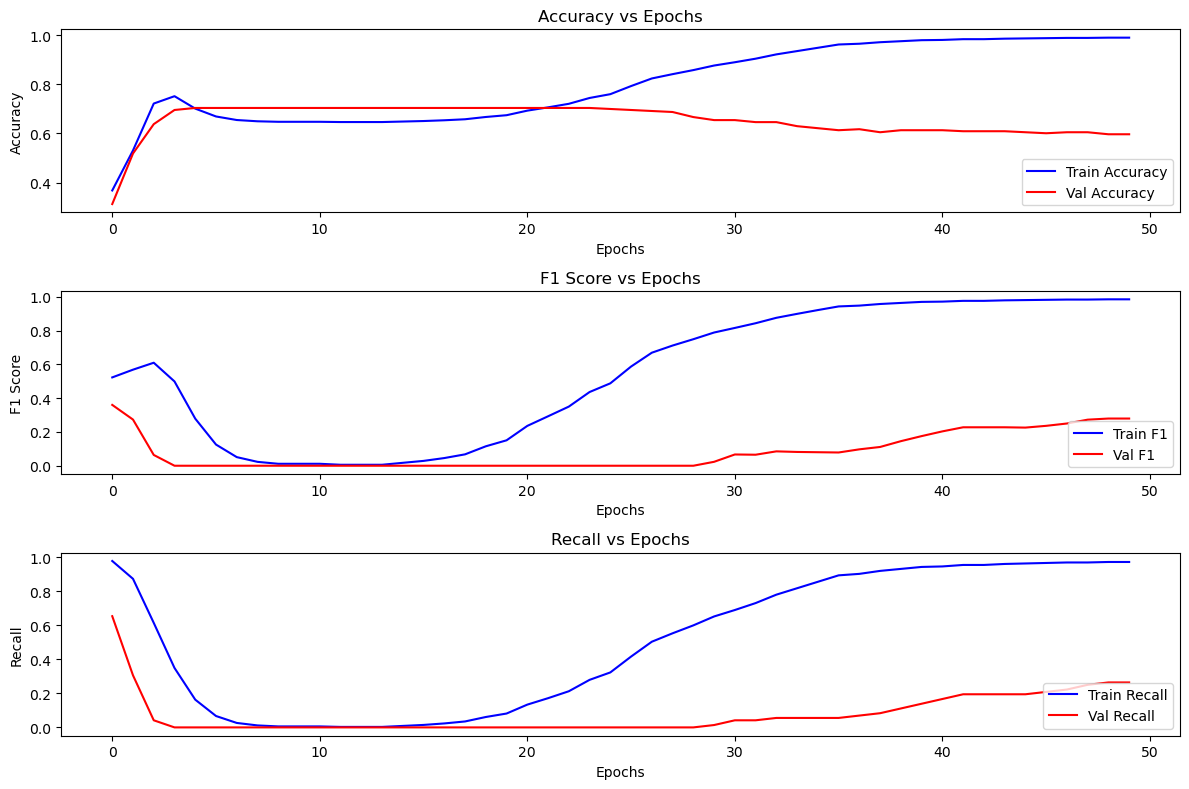

In [78]:
# Instantiate model
model = SimpleNN(input_dim=X_train.shape[1])

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss(
    pos_weight=class_weights[1]
)  # weight for the minority class

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store metrics
train_acc_list = []
train_f1_list = []
train_recall_list = []
val_acc_list = []
val_f1_list = []
val_recall_list = []

# Training loop
n_epochs = 50
for epoch in range(n_epochs):
    model.train()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Apply threshold to get binary predictions
    preds_train = (outputs > 0.5).float()

    # Compute metrics for training
    train_acc = accuracy_score(y_train_tensor.numpy(), preds_train.numpy())
    train_f1 = f1_score(y_train_tensor.numpy(), preds_train.numpy())
    train_recall = recall_score(y_train_tensor.numpy(), preds_train.numpy())

    # Append metrics to lists
    train_acc_list.append(train_acc)
    train_f1_list.append(train_f1)
    train_recall_list.append(train_recall)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

        # Apply threshold to get binary predictions for validation
        preds_val = (val_outputs > 0.5).float()

        # Compute metrics for validation
        val_acc = accuracy_score(y_val_tensor.numpy(), preds_val.numpy())
        val_f1 = f1_score(y_val_tensor.numpy(), preds_val.numpy())
        val_recall = recall_score(y_val_tensor.numpy(), preds_val.numpy())

        # Append validation metrics to lists
        val_acc_list.append(val_acc)
        val_f1_list.append(val_f1)
        val_recall_list.append(val_recall)

    if epoch % 5 == 0:
        print(
            f"Epoch [{epoch}/{n_epochs}] - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f} "
            f"- Train Accuracy: {train_acc:.4f} - Train F1: {train_f1:.4f} - Train Recall: {train_recall:.4f} "
            f"- Val Accuracy: {val_acc:.4f} - Val F1: {val_f1:.4f} - Val Recall: {val_recall:.4f}"
        )

# Plotting the metrics
epochs = list(range(n_epochs))

plt.figure(figsize=(12, 8))

# Plot accuracy
plt.subplot(3, 1, 1)
plt.plot(epochs, train_acc_list, label="Train Accuracy", color="b")
plt.plot(epochs, val_acc_list, label="Val Accuracy", color="r")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy vs Epochs")

# Plot F1 score
plt.subplot(3, 1, 2)
plt.plot(epochs, train_f1_list, label="Train F1", color="b")
plt.plot(epochs, val_f1_list, label="Val F1", color="r")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend(loc="lower right")
plt.title("F1 Score vs Epochs")

# Plot recall
plt.subplot(3, 1, 3)
plt.plot(epochs, train_recall_list, label="Train Recall", color="b")
plt.plot(epochs, val_recall_list, label="Val Recall", color="r")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(loc="lower right")
plt.title("Recall vs Epochs")

plt.tight_layout()
plt.show()

### Do separate models for sex and ADHD

#### Sex prediction

In [113]:
# Step 1: Scale inputs if needed (as you've done previously)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [114]:
# Step 2: Convert the data to DMatrix (XGBoost format)
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dval = xgb.DMatrix(X_val_scaled, label=y_val)

In [130]:
# Step 3: Set up parameters
params = {
    "objective": "binary:logistic",  # Binary classification
    "eval_metric": "logloss",  # Log loss evaluation metric
    "scale_pos_weight": len(y_train) / sum(y_train),  # Handling class imbalance
    "max_depth": 10,  # Maximum depth of the trees
    "eta": 0.001,  # Learning rate
    "subsample": 0.8,  # Subsample ratio of the training data
    "colsample_bytree": 0.8,  # Subsample ratio of features
    "nthread": 4,  # Number of threads (adjust based on your system)
}

In [131]:
# Step 4: Set up evaluation
evals = [(dtrain, "train"), (dval, "validation")]

In [132]:
# Step 5: Train the model
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=100,  # Number of boosting rounds
    evals=evals,
    early_stopping_rounds=10,  # Stop if validation error doesn't improve
)

[0]	train-logloss:0.77822	validation-logloss:0.80385
[1]	train-logloss:0.77748	validation-logloss:0.80359
[2]	train-logloss:0.77681	validation-logloss:0.80341
[3]	train-logloss:0.77623	validation-logloss:0.80333
[4]	train-logloss:0.77559	validation-logloss:0.80311
[5]	train-logloss:0.77485	validation-logloss:0.80282
[6]	train-logloss:0.77426	validation-logloss:0.80263
[7]	train-logloss:0.77363	validation-logloss:0.80241
[8]	train-logloss:0.77292	validation-logloss:0.80233
[9]	train-logloss:0.77224	validation-logloss:0.80213
[10]	train-logloss:0.77151	validation-logloss:0.80203
[11]	train-logloss:0.77082	validation-logloss:0.80179
[12]	train-logloss:0.77024	validation-logloss:0.80162
[13]	train-logloss:0.76957	validation-logloss:0.80162
[14]	train-logloss:0.76885	validation-logloss:0.80144
[15]	train-logloss:0.76818	validation-logloss:0.80114
[16]	train-logloss:0.76758	validation-logloss:0.80103
[17]	train-logloss:0.76685	validation-logloss:0.80079
[18]	train-logloss:0.76616	validation-

In [133]:
# Step 6: Make predictions
y_pred_prob = bst.predict(dval)  # Probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Step 7: Evaluate model
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.2963
F1 Score: 0.4571
Recall: 1.0000


#### ADHD prediction

In [134]:
# dtrain_adhd = xgb.DMatrix(X_train, label=y_adhd_train)
# dval_adhd = xgb.DMatrix(X_val, label=y_adhd_val)

# params_adhd = {
#     "objective": "binary:logistic",  # binary classification (0/1)
#     "eval_metric": "logloss",  # how well the model is doing
#     "booster": "gbtree",  # use gradient boosted trees (the default)
#     "eta": 0.1,  # learning rate
#     "max_depth": 6,  # maximum depth of trees
#     "subsample": 0.8,  # randomly sample 80% of data per tree
#     "colsample_bytree": 0.8,  # randomly sample 80% of features per tree
#     "seed": 42,
# }

# bst_adhd = xgb.train(
#     params_adhd,
#     dtrain_adhd,
#     num_boost_round=100,
#     evals=[(dtrain_adhd, "train"), (dval_adhd, "validation")],
#     early_stopping_rounds=10,
# )